In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, confusion_matrix, accuracy_score


In [60]:
ssn1011 = pd.read_excel('../Downloads/season-1011.xlsm', sheet_name="season-1011 (Loss = -1)")

In [61]:
ssn1011.head()

,Div,H/A,Date,Team_Name,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,Win_Dummy,Home_Dummy,Goal_Diff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,H,14/08/10,Aston Villa,3.0,0.0,H,2.0,0.0,H,...,1.75,20.0,0.0,1.45,1.40,3.00,2.78,1.0,1.0,3.0
2,NaN,A,14/08/10,West Ham,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,-3.0
3,E0,H,14/08/10,Blackburn,1.0,0.0,H,1.0,0.0,H,...,1.70,29.0,0.0,2.20,2.05,1.85,1.75,1.0,1.0,1.0
4,NaN,A,14/08/10,Everton,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,-1.0


# Data Preprocessing

In [58]:
# change name of column H/A due to special character
ssn1011_tf = ssn1011[['H/A','Date','Team_Name','FTHG','FTAG','Win_Dummy','Home_Dummy','Goal_Diff']]
ssn1011_tf = ssn1011_tf.rename(columns={"H/A": "H_A"})

In [6]:
# drop first row
ssn1011_tf = ssn1011_tf.drop([0])
ssn1011_tf.head()

,H_A,Date,Team_Name,FTHG,FTAG,Win_Dummy,Home_Dummy,Goal_Diff
1,H,14/08/10,Aston Villa,3.0,0.0,1.0,1.0,3.0
2,A,14/08/10,West Ham,NaN,NaN,-1.0,0.0,-3.0
3,H,14/08/10,Blackburn,1.0,0.0,1.0,1.0,1.0
4,A,14/08/10,Everton,NaN,NaN,-1.0,0.0,-1.0
5,H,14/08/10,Bolton,0.0,0.0,0.0,1.0,0.0


In [7]:
ssn1011_tf.update(ssn1011_tf[['FTHG','FTAG']].fillna(0.0))
ssn1011_tf.head()

,H_A,Date,Team_Name,FTHG,FTAG,Win_Dummy,Home_Dummy,Goal_Diff
1,H,14/08/10,Aston Villa,3.0,0.0,1.0,1.0,3.0
2,A,14/08/10,West Ham,0.0,0.0,-1.0,0.0,-3.0
3,H,14/08/10,Blackburn,1.0,0.0,1.0,1.0,1.0
4,A,14/08/10,Everton,0.0,0.0,-1.0,0.0,-1.0
5,H,14/08/10,Bolton,0.0,0.0,0.0,1.0,0.0


In [8]:
# categorize H/A column
h_a = {
    "H" : 1,
    "A" : 2
}
ssn1011_tf["H_A_Num"] = ssn1011_tf.H_A.map(h_a)

In [9]:
ssn1011_tf.head()

,H_A,Date,Team_Name,FTHG,FTAG,Win_Dummy,Home_Dummy,Goal_Diff,H_A_Num
1,H,14/08/10,Aston Villa,3.0,0.0,1.0,1.0,3.0,1
2,A,14/08/10,West Ham,0.0,0.0,-1.0,0.0,-3.0,2
3,H,14/08/10,Blackburn,1.0,0.0,1.0,1.0,1.0,1
4,A,14/08/10,Everton,0.0,0.0,-1.0,0.0,-1.0,2
5,H,14/08/10,Bolton,0.0,0.0,0.0,1.0,0.0,1


In [10]:
# get unique team names for categorization
# how should we categorize/rank these?
ssn1011_tf.Team_Name.unique()

array(['Aston Villa', 'West Ham', 'Blackburn', 'Everton', 'Bolton',
       'Fulham', 'Chelsea', 'West Brom', 'Sunderland', 'Birmingham',
       'Tottenham', 'Man City', 'Wigan', 'Blackpool', 'Wolves', 'Stoke',
       'Liverpool', 'Arsenal', 'Man United', 'Newcastle'], dtype=object)

In [11]:
# drop the columns where we replaced with numbers
drop_cols = ['H_A', 'Date']
for col in drop_cols:
    ssn1011_tf.drop(col, axis=1, inplace=True)

ssn1011_tf.head()

,Team_Name,FTHG,FTAG,Win_Dummy,Home_Dummy,Goal_Diff,H_A_Num
1,Aston Villa,3.0,0.0,1.0,1.0,3.0,1
2,West Ham,0.0,0.0,-1.0,0.0,-3.0,2
3,Blackburn,1.0,0.0,1.0,1.0,1.0,1
4,Everton,0.0,0.0,-1.0,0.0,-1.0,2
5,Bolton,0.0,0.0,0.0,1.0,0.0,1


In [19]:
# shows how much correlation each feature has against the target variable
orr_matrix = ssn1011_tf.corr()
corr_matrix['Win_Dummy'] = round(corr_matrix['Win_Dummy'],4)
corr_matrix['Win_Dummy'].sort_values(ascending=False)

Win_Dummy     1.0000
Goal_Diff     0.8576
FTHG          0.4806
Home_Dummy    0.2784
FTAG         -0.1880
H_A_Num      -0.2784
Name: Win_Dummy, dtype: float64

In [20]:
#Independent variable:
x= ssn1011_tf.loc[:,~ssn1011_tf.columns.isin(['Team_Name', 'Win_Dummy'])]

#dependent variable:
y=ssn1011_tf.loc[:,'Win_Dummy']

In [21]:
# split dataset into training/test sets
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3,random_state=42)

In [22]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

# Linear Regression

In [23]:
ln_reg=LinearRegression()

In [24]:
ln_reg.fit(x_train,y_train)

LinearRegression()

In [25]:
ln_y_pred=ln_reg.predict(x_test)

In [26]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ln_y_pred),
      '\nMSE = ', mean_squared_error(y_test,ln_y_pred),
      '\nr2_score = ', r2_score(y_test,ln_y_pred))

MAPE =  194.5343498339725 
MSE =  0.18154976447988402 
r2_score =  0.7395998411631959


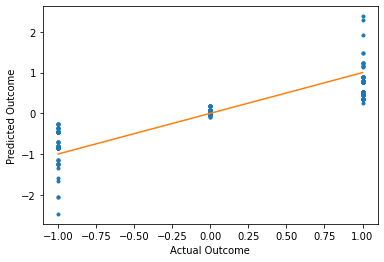

In [27]:
plt.plot(y_test, ln_y_pred, '.')

x = np.linspace(-1, 1)
y = x
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.plot(x, y)
plt.show()

In [33]:
# dataframe showing predicted outcome
out_df = x_test.copy()
out_df['Actual_Target'] = y_test
out_df['Predicted_Target'] = ln_y_pred
out_df['Predicted_Target_Rounded'] = ln_y_pred.round()
out_df = out_df[(out_df.Predicted_Target_Rounded >= -1) & (out_df.Predicted_Target_Rounded <= 1)]

out_df = out_df.replace(-0.0, 0.0)
out_df

,FTHG,FTAG,Home_Dummy,Goal_Diff,H_A_Num,Actual_Target,Predicted_Target,Predicted_Target_Rounded
396,0.0,0.0,0.0,-2.0,2,-1.0,-0.853468,-1.0
325,3.0,1.0,1.0,2.0,1,1.0,0.790930,1.0
98,0.0,0.0,0.0,-1.0,2,-1.0,-0.448657,0.0
498,0.0,0.0,0.0,-1.0,2,-1.0,-0.448657,0.0
110,0.0,0.0,0.0,0.0,2,0.0,-0.043845,0.0
...,...,...,...,...,...,...,...,...
569,3.0,1.0,1.0,2.0,1,1.0,0.790930,1.0
19,3.0,0.0,1.0,3.0,1,1.0,1.234259,1.0
753,0.0,1.0,1.0,-1.0,1,-1.0,-0.261716,0.0
141,2.0,1.0,1.0,1.0,1,1.0,0.440048,0.0


In [34]:
accuracy = accuracy_score(y_test, ln_y_pred.round())*100
print('accuracy score', accuracy.round(2), '%')

accuracy score 65.79 %


In [35]:
# confusion matrix
y_actu = pd.Series(out_df['Actual_Target'], name='Actual')
y_pred = pd.Series(out_df['Predicted_Target_Rounded'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,30,43,0
0.0,0,69,0
1.0,0,27,51


# Decision Tree

In [38]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [39]:
dt_y_pred=regressor_dt.predict(x_test)

In [40]:
# mean_absolute_percentage_error(y_test,dt_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dt_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dt_y_pred),
      '\nr2_score = ', r2_score(y_test,dt_y_pred))

MAPE =  0.0 
MSE =  0.0 
r2_score =  1.0


In [50]:
dt_df = x_test.copy()
dt_df['Actual_Target'] = y_test
dt_df['Predicted_Target'] = dt_y_pred
dt_df['Predicted_Target_Rounded'] = dt_y_pred.round()
dt_df = dt_df[(dt_df.Predicted_Target_Rounded >= -1) & (dt_df.Predicted_Target_Rounded <= 1)]

dt_df = dt_df.replace(-0.0, 0.0)
dt_df

,FTHG,FTAG,Home_Dummy,Goal_Diff,H_A_Num,Actual_Target,Predicted_Target,Predicted_Target_Rounded
396,0.0,0.0,0.0,-2.0,2,-1.0,-1.0,-1.0
325,3.0,1.0,1.0,2.0,1,1.0,1.0,1.0
98,0.0,0.0,0.0,-1.0,2,-1.0,-1.0,-1.0
498,0.0,0.0,0.0,-1.0,2,-1.0,-1.0,-1.0
110,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
569,3.0,1.0,1.0,2.0,1,1.0,1.0,1.0
19,3.0,0.0,1.0,3.0,1,1.0,1.0,1.0
753,0.0,1.0,1.0,-1.0,1,-1.0,-1.0,-1.0
141,2.0,1.0,1.0,1.0,1,1.0,1.0,1.0


In [51]:
accuracy = accuracy_score(y_test, dt_y_pred.round())*100
print('accuracy score', accuracy.round(2), '%')

accuracy score 100.0 %


In [52]:
y_actu = pd.Series(dt_df['Actual_Target'], name='Actual')
y_pred = pd.Series(dt_df['Predicted_Target_Rounded'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,78,0,0
0.0,0,69,0
1.0,0,0,81


#  Lasso Regression

In [42]:
lasso_regressor = LassoCV()
lasso_regressor.fit(x_train,y_train)

LassoCV()

In [43]:
lasso_y_pred=lasso_regressor.predict(x_test)

In [44]:
print('MAPE = ', mean_absolute_percentage_error(y_test,lasso_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,lasso_y_pred),
      '\nr2_score = ', r2_score(y_test,lasso_y_pred))

MAPE =  181.33648302374124 
MSE =  0.18161194473810732 
r2_score =  0.7395106548777481


In [45]:
lr_df = x_test.copy()
lr_df['Actual_Target'] = y_test
lr_df['Predicted_Target'] = lasso_y_pred
lr_df['Predicted_Target_Rounded'] = lasso_y_pred.round()
lr_df = lr_df[(lr_df.Predicted_Target_Rounded >= -1) & (lr_df.Predicted_Target_Rounded <= 1)]

lr_df = lr_df.replace(-0.0, 0.0)
lr_df

,FTHG,FTAG,Home_Dummy,Goal_Diff,H_A_Num,Actual_Target,Predicted_Target,Predicted_Target_Rounded
396,0.0,0.0,0.0,-2.0,2,-1.0,-0.850251,-1.0
325,3.0,1.0,1.0,2.0,1,1.0,0.793896,1.0
98,0.0,0.0,0.0,-1.0,2,-1.0,-0.445898,0.0
498,0.0,0.0,0.0,-1.0,2,-1.0,-0.445898,0.0
110,0.0,0.0,0.0,0.0,2,0.0,-0.041545,0.0
...,...,...,...,...,...,...,...,...
569,3.0,1.0,1.0,2.0,1,1.0,0.793896,1.0
19,3.0,0.0,1.0,3.0,1,1.0,1.232405,1.0
753,0.0,1.0,1.0,-1.0,1,-1.0,-0.273172,0.0
141,2.0,1.0,1.0,1.0,1,1.0,0.438207,0.0


In [46]:
accuracy = accuracy_score(y_test, lasso_y_pred.round())*100
print('accuracy score', accuracy.round(2), '%')

accuracy score 64.91 %


In [53]:
y_actu = pd.Series(lr_df['Actual_Target'], name='Actual')
y_pred = pd.Series(lr_df['Predicted_Target_Rounded'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,-1.0,0.0,1.0
Actual,,,
-1.0,30,43,0
0.0,0,69,0
1.0,0,27,49
